## Implementing an efficient rolling average algorithm with stride tricks
Stride tricks can be useful for local computation on arrays, when the computed value at a given position depends on the neighboring values. E.g. dynamical systems, digital filters, cellular automata.

**Rolling average** algorithm is a particular type of convolution-based linear filter. A rolling average of a 1D vector contains, at each position, the average of the elements around this position in the original vector. Roughly speaking, this process filters out the noisy components of a singal so as to keep only the slower components.

In [19]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
import numpy as np
from numpy.lib.stride_tricks import as_strided

In [3]:
def aid(x):
    # This function returns the memory
    # block address of an array.
    return x.__array_interface__['data'][0]

In [4]:
n = 5
k = 2
a = np.linspace(1, n, n)
ax = aid(a)

Change the strides of `a` to add shifted rows:

In [5]:
as_strided(a, (k, n), (8, 8))

array([[1.00000000e+000, 2.00000000e+000, 3.00000000e+000,
        4.00000000e+000, 5.00000000e+000],
       [2.00000000e+000, 3.00000000e+000, 4.00000000e+000,
        5.00000000e+000, 4.17201348e-309]])

The last value indicates an out-of-bounds problem: stride ticks can be dangerous as memory access is not checked. Here, we should take edge effects into account by limiting the shape of the array.

3. Let's implement the computation of the rolling average. The first version (standard method) involves explicit array copies, where as the second version uses stride tricks:

In [6]:
def shift1(x, k):
    return np.vstack([x[i: n - k + i + 1] for i in range(k)])

def shift2(x, k):
    return as_strided(x, (k, n - k + 1), (x.itemsize, x.itemsize))

4. These two functions return the same result, except that the array returned by the second function refers to the original data buffer:

In [7]:
b = shift1(a, k)
b

array([[1., 2., 3., 4.],
       [2., 3., 4., 5.]])

In [9]:
aid(b) == ax

False

In [10]:
c = shift2(a, k)
c

array([[1., 2., 3., 4.],
       [2., 3., 4., 5.]])

In [11]:
aid(c) == ax

True

5. Let's generate a signal and compute the rolling average

In [12]:
n, k = 1000, 10
t = np.linspace(0., 1., n)
x = t + .1 * np.random.randn(n)

6. We compute the signal rolling average by creating the shifted version of the signal, and averaging along the vertical dimension:

In [13]:
y = shift2(x, k)
x_avg = y.mean(axis=0)

7. Let's plot these arrays:

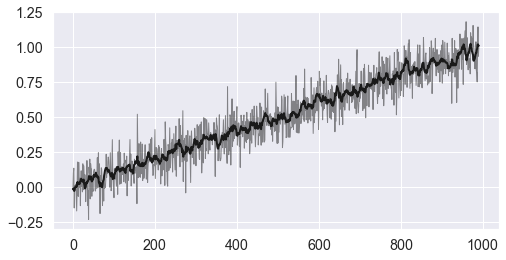

In [20]:
import seaborn as sns
sns.set(font_scale=1.3, font='Arial')
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(x[:-k+1], '-k', lw=1, alpha=.5)
ax.plot(x_avg, '-k', lw=2)

8. Let's evaluate the time taken by the first method:

In [21]:
%timeit shift1(x, k)

18.4 µs ± 352 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [22]:
%%timeit y = shift2(x, k)
z = y.mean(axis=0)

11 µs ± 63 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
